In [134]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
import jax
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder


In [147]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [148]:
df = df[df.date > '2021-10-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x == 'BA.1')))
all = df.groupby(['sending_pc','date'])['omi'].count()
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy()

In [149]:

meta = pd.read_csv("data/plz_metadata.csv",dtype={'zipcode':str})[['zipcode','latitude','longitude','inc_2021-11-25','inc_2021-12-10']]
df_filtered = df_filtered.join(meta.set_index('zipcode'), on='sending_pc')


In [171]:
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)
omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['sending_area'].values
sending_inc_start = np.log(df_filtered['inc_2021-11-25']).values / 15
sending_inc_end = np.log(df_filtered['inc_2021-12-10']).values / 15

In [172]:
df_filtered[df_filtered['inc_2021-11-25'].isna()].sending_pc.unique()

array([], dtype=object)

In [173]:
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {k: LocScaleReparam(0) for k in ["a"]}

@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sample_day, total_counts, sending_inc_start=None, sending_inc_end=None, omi_counts=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0, 3.0))
    sigma_a = numpyro.sample("sigma", dist.HalfNormal(2.0))
    b = numpyro.sample("b", dist.Normal(0.2, 0.2))
    c_start = numpyro.sample("c_start", dist.Normal(0,3))
    b_diff = numpyro.sample("b_diff", dist.Normal(0, 3))


    n_labs = len(np.unique(sending_pc))

    n_days = int(len(total_counts)/n_labs)

    with numpyro.plate("plate_j", n_labs):
        a = numpyro.sample("a", dist.Normal(mu_a, sigma_a))
    
    logit_today = numpyro.deterministic("logit_today", (a[sending_pc] + c_start * sending_inc_start)[::n_days])
    b_eff = numpyro.deterministic("b_eff",(b + b_diff * (sending_inc_end-sending_inc_start))[::n_days])

    logit_est = a[sending_pc] + c_start * sending_inc_start + (b + b_diff * (sending_inc_end-sending_inc_start)) * sample_day

    with numpyro.plate("data", len(total_counts)):
        numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)


In [174]:

nuts_kernel = NUTS(model3)

mcmc = MCMC(nuts_kernel, num_samples=1500, num_warmup=500)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sending_pc_ID, sample_day, total_counts, sending_inc_start=sending_inc_start,sending_inc_end=sending_inc_end, omi_counts=omi_counts)

sample: 100%|██████████| 2000/2000 [00:42<00:00, 47.22it/s, 127 steps of size 3.08e-02. acc. prob=0.91]


In [177]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 a_decentered[0]     -1.42      0.50     -1.38     -2.14     -0.52    941.25      1.00
 a_decentered[1]     -0.10      0.42     -0.07     -0.80      0.55   1101.85      1.00
 a_decentered[2]     -0.70      0.75     -0.64     -1.85      0.54   1614.68      1.00
 a_decentered[3]     -0.75      0.72     -0.72     -1.92      0.42   1074.44      1.00
 a_decentered[4]     -0.96      0.70     -0.93     -2.15      0.14   1765.20      1.00
 a_decentered[5]     -0.28      0.81     -0.24     -1.60      1.02   2047.83      1.00
 a_decentered[6]     -0.09      0.61     -0.06     -1.00      0.95   1416.53      1.00
 a_decentered[7]     -0.34      0.82     -0.32     -1.67      1.01   2175.95      1.00
 a_decentered[8]      0.39      0.26      0.39     -0.05      0.77    319.81      1.00
 a_decentered[9]     -1.08      0.64     -1.03     -2.02      0.06   2056.07      1.00
a_decentered[10]      0.37      0.43      

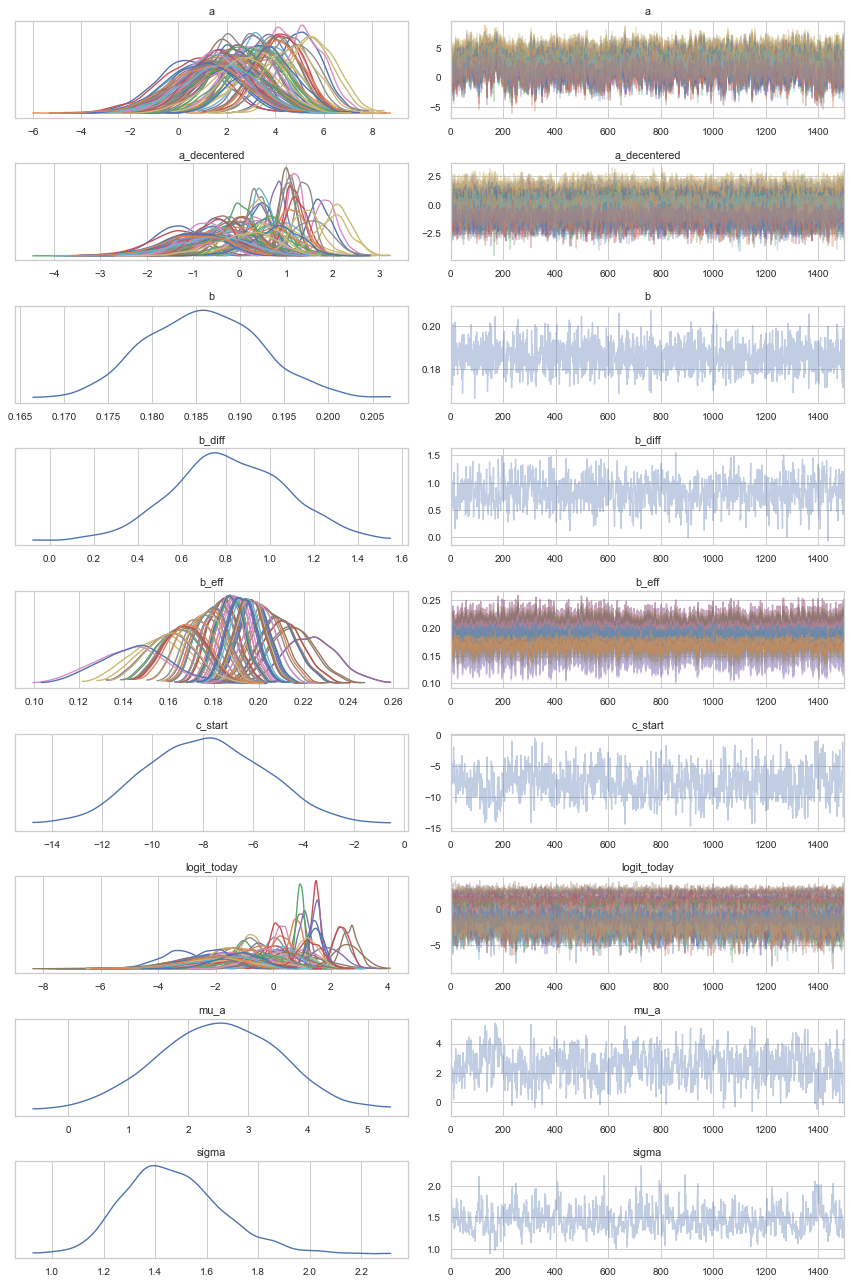

In [178]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [179]:
s = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(s['b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(s['b']['5.0%'])-1:.1%}, {np.exp(s['b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+s['b']['mean']):.2} Tage mit 90%-Konfidenzintervall [{np.log(2)/np.log(1+s['b']['95.0%']):.2},{np.log(2)/np.log(1+s['b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    20.4% mit 90%-Konfidenzintervall [19.1%, 21.7%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    4.1 Tage mit 90%-Konfidenzintervall [3.9,4.3]
    


92


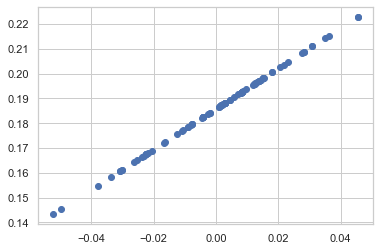

In [180]:
print(len(s['b_eff']['mean']))
plt.scatter((sending_inc_end-sending_inc_start)[::int(len(sending_inc_end)/len(s['b_eff']['mean']))],s['b_eff']['mean'])


In [114]:
logits = s['b_eff']
logits

OrderedDict([('mean',
              array([0.17767785, 0.17767785, 0.17376715, 0.18650635, 0.18650635,
                     0.20768176, 0.17454308, 0.17806664, 0.17586355, 0.19882438,
                     0.19909616, 0.18376778, 0.16704659, 0.19136171, 0.19136171,
                     0.19136171, 0.18833746, 0.20054004, 0.20054004, 0.20385163,
                     0.20194708, 0.20194708, 0.20058021, 0.20194708, 0.20194708,
                     0.20194708, 0.20094667, 0.18004338, 0.18968718, 0.19561052,
                     0.19561052, 0.19561052, 0.19012046, 0.2108273 , 0.18693034,
                     0.18599273, 0.19374524, 0.19235861, 0.19235861, 0.19844158,
                     0.18750203, 0.18750203, 0.18609308, 0.19285966, 0.18619472,
                     0.20287226, 0.20287226, 0.20287226, 0.18372662, 0.18912661,
                     0.18912661, 0.1830992 , 0.18487355, 0.18487355, 0.19434366,
                     0.19434366, 0.18501674, 0.18501674, 0.1893986 , 0.19500986,
      

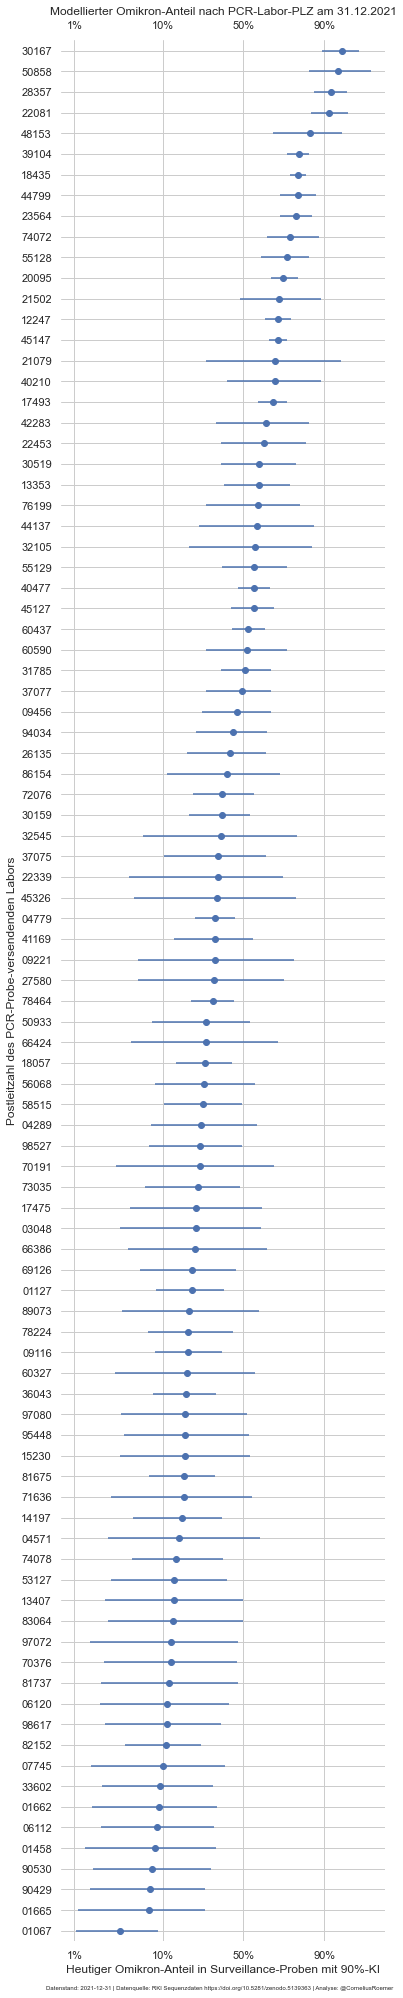

In [181]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
pdf = pd.DataFrame(s['logit_today'])
pdf['plz'] = le.inverse_transform(pdf.index.values)
pdf.set_index('plz',inplace=True)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5,30)) 
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values,xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.set(title=f'Modellierter Omikron-Anteil nach PCR-Labor-PLZ am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.02)
fig.text(0.49, -0.003, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_pc.png",dpi=300,bbox_inches='tight',pad_inches=0.2)

Es gibt drei klare Ausreißer die entfernt wurden. Für mehr Details zu Outliern siehe das Notebook [Outlier Labs](outlier_labs.ipynb).

In [182]:
pdf = pd.DataFrame(s['mu_a'])
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Postleitzahlgebiet am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahlgebiet des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

ValueError: If using all scalar values, you must pass an index